### Цели практической работы
- Составить аналитическую отчётность по результатам проведённой работы (в том числе с использованием визуализаций).
- Составить аналитическую презентацию для менеджмента по результатам проведённой работы (в том числе с использованием визуализаций).


### Что нужно сделать
Вы провели целостный многоэтапный анализ данных и получили значимые результаты после моделирования и А/В-тестов. 

Теперь вам нужно представить аналитический отчёт линейному начальству и выйти с презентацией для вышестоящего руководства.

У вас есть разумные ограничения: аналитический отчёт не может быть больше десяти страниц, а презентация не может длиться дольше десяти минут.

### Советы и рекомендации
- Придерживайтесь принципа пирамиды Минто, так как у руководства не всегда есть время вникать в детали.
- Ваш линейный руководитель — технический специалист, который хочет погрузиться в детали работы и проверить, не допустили ли вы ошибку.
- Вышестоящее руководство — менеджмент, для которого важен бизнес-эффект, но у руководителя нет экспертизы в технических деталях.
- Отчёт и презентация должны показать, почему ваш путь самый оптимальный и результативный.
- Продемонстрируйте не только технические, но и бизнес-результаты, чтобы решение можно быть внедрить в продакшен.
- Придерживайтесь принципов подготовки отчётов и презентаций из этого модуля.

In [396]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import requests
import xml.etree.ElementTree as ET
import urbangrammar_graphics as ugg

from scipy import stats
from scipy.stats import ttest_ind
from scipy.cluster.hierarchy import dendrogram

from sqlalchemy import create_engine
from sqlalchemy import text
from dateutil.parser import parse 
from clustergram import Clustergram

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from kmodes.kprototypes import KPrototypes

## 1. Формируем витрину данных с текущим курсом валют

In [397]:
# API с курсами валют 
r = requests.get('https://cbr.ru/scripts/XML_daily.asp?')

In [398]:
with open('cbr.xml', 'w') as f:
    f.write(r.text)

In [399]:
def export_xml_to_csv_func():
    parser = ET.XMLParser(encoding='Windows-1251')
    tree = ET.parse('cbr.xml', parser=parser)
    root = tree.getroot()

    with open('cbr.csv', 'w') as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for Valute in root.findall('Valute'):
            NumCode = Valute.find('NumCode').text
            CharCode = Valute.find('CharCode').text
            Nominal = Valute.find('Nominal').text
            Name = Valute.find('Name').text
            Value = Valute.find('Value').text
            writer.writerow([root.attrib['Date']] + [Valute.attrib['ID']] + [NumCode] + [CharCode] + [Nominal] +
                            [Name] + [Value.replace(',', '.')])
            
export_xml_to_csv_func()
df = pd.read_csv('cbr.csv', encoding='Windows-1251', header=None)
rate_df = df.rename(columns={
    0: 'rate_dt',
    2: 'currency_id',
    3: 'currency_cd',
    4: 'nominal_qty',
    5: 'currency_nm',
    6: 'currency_rate'})[['rate_dt', 'currency_id', 'currency_cd', 'nominal_qty', 'currency_nm', 'currency_rate']]

In [400]:
rate_df.head(3)

,rate_dt,currency_id,currency_cd,nominal_qty,currency_nm,currency_rate
0,07.10.2023,36,AUD,1,Австралийский доллар,63.9927
1,07.10.2023,944,AZN,1,Азербайджанский манат,59.1124
2,07.10.2023,826,GBP,1,Фунт стерлингов Соединенного королевства,122.1972


In [418]:
contracts = pd.read_excel('CASE_CONTRACTS.xlsx')
losses = pd.read_excel('CASE_LOSSES.xlsx')
clients = pd.read_excel('CASE_CLIENTS.xlsx')

In [402]:
group = pd.read_excel('experiment_group.xlsx')
print(group.shape)
x = group.shape[0] - group['group'].isnull().sum ()
print(f'Количество клиентов, попавших в группы ---- {x}')
group.head(2)

(14842, 3)
Количество клиентов, попавших в группы ---- 12349


,client_id,group,experiment_id
0,10001718,control,policy_pricing
1,1017180395,control,policy_pricing


In [419]:
result = contracts.join(other=clients.set_index('client_id'), on='client_id')
result = result.merge(losses[['client_id','loss_payout_amt']], on='client_id', how='left')
# так как количество клиентов с группировкой намного выше рассматриваемой выборки, добавляем к рассматриваемой выборке группировку
# далее будем исследовать первоначальную выборку - там, где применялась традиционная цена
result = pd.merge(result, group[["client_id", "group"]], on = "client_id", how='left')

In [406]:
# Используем функции конвертеры валют
def get_all_exchange_rates_erapi(src):
    url = f"https://open.er-api.com/v6/latest/{src}"
    # request the open ExchangeRate API and convert to Python dict using .json()
    data = requests.get(url).json()
    if data["result"] == "success":
        # request successful
        # get the last updated datetime
        last_updated_datetime = parse(data["time_last_update_utc"])
        # get the exchange rates
        exchange_rates = data["rates"]
    return last_updated_datetime, exchange_rates

def convert_currency_erapi(src, dst):
    # get all the exchange rates
    last_updated_datetime, exchange_rates = get_all_exchange_rates_erapi(src)
    # convert by simply getting the target currency exchange rate and multiply by the amount
    return exchange_rates[dst]

In [420]:
a = convert_currency_erapi('USD', 'RUB')
result['price_USD'] = np.where(result['currency_name'] == 'Российский рубль', (result['price']/a).round(2), result['price'])
result['insurance_amount_USD'] = np.where(result['currency_name'] == 'Российский рубль', (result['insurance_amount']/a).round(2), result['insurance_amount'])
result['insurance_amount_USD']
result['loss_payout_amt_USD'] = (result['loss_payout_amt'] / a).round(2)

In [421]:
result = result.drop(columns=['product_name', 'currency_name', 'price', 'insurance_amount','loss_payout_amt'])

In [422]:
result.to_excel('result_1.xlsx', index= False)

In [423]:
result = pd.read_excel('result_1.xlsx')

#  Выводы при формировании витрины данных
1. Читаем исходные файлы с информацией по контрактам, по покупателям, по убыткам, 
2. Скачиваем курс валют с сайта ЦБ РФ, преобразуем, считываем данные, пересчитываем ценовые характеристики в единый формат валют - доллар
3. Так как вид продукта по контракту теперь один - страхование путешественников, а также в связи с тем, что все цены приведены к доллару, удаляем из витрины данных лишние столбцы.

!!! Количество id контрактов =  количеству id клиентов

## 2. Исследуем, заполняем датасет

In [424]:
result

,contract_id,contract_num,client_id,contract_status,duration,country,last_name,first_name,middle_name,age,sex,group,price_USD,insurance_amount_USD,loss_payout_amt_USD
0,21111219,ТТЕ7227715*****,10161870404,Действует,10,Беларусь,А*****,Х*****,А*****,20,M,test,10.90,19890.88,NaN
1,21111381,ТТЕ7227715*****,1017159879,Действует,7,Индонезия,З*****,Х*****,М*****,55,M,control,19.08,49727.19,NaN
2,21112353,БАДАМСТЕ55*****,10161883357,Действует,10,Беларусь,Б*****,В*****,Щ*****,61,F,control,10.90,19890.88,NaN
3,21113224,ТТЕ7227715*****,100766461,Действует,14,Грузия,И*****,У*****,Н*****,25,M,control,15.26,19890.88,NaN
4,21113292,ТТЕ7227715*****,10171604758,Действует,7,Аргентина,З*****,Ч*****,Г*****,33,M,control,19.08,49727.19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3706,31133782315,ДСЖ-5/1539*****,100649013,Действует,15,Турция,В*****,В*****,Н*****,22,F,control,24.53,29836.31,NaN
3707,31133836775,ТТЕ7227778*****,1017151314,Действует,7,Индонезия,Е*****,Ш*****,Э*****,33,M,control,19.08,49727.19,NaN
3708,31133933241,БТАСЕ275 -*****,1006491844,Действует,15,Турция,Г*****,Г*****,И*****,43,M,test,24.53,29836.31,NaN
3709,3114463583,ТТЕ7227778*****,1006513037,Действует,30,Турция,Б*****,П*****,П*****,29,M,control,49.05,29836.31,NaN


In [425]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3711 entries, 0 to 3710
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   contract_id           3711 non-null   int64  
 1   contract_num          3711 non-null   object 
 2   client_id             3711 non-null   int64  
 3   contract_status       3711 non-null   object 
 4   duration              3711 non-null   int64  
 5   country               3711 non-null   object 
 6   last_name             3711 non-null   object 
 7   first_name            3693 non-null   object 
 8   middle_name           3453 non-null   object 
 9   age                   3711 non-null   int64  
 10  sex                   3711 non-null   object 
 11  group                 3616 non-null   object 
 12  price_USD             3711 non-null   float64
 13  insurance_amount_USD  3711 non-null   float64
 14  loss_payout_amt_USD   45 non-null     float64
dtypes: float64(3), int64(

### 2.1. Заполняем пропуски

<AxesSubplot:>

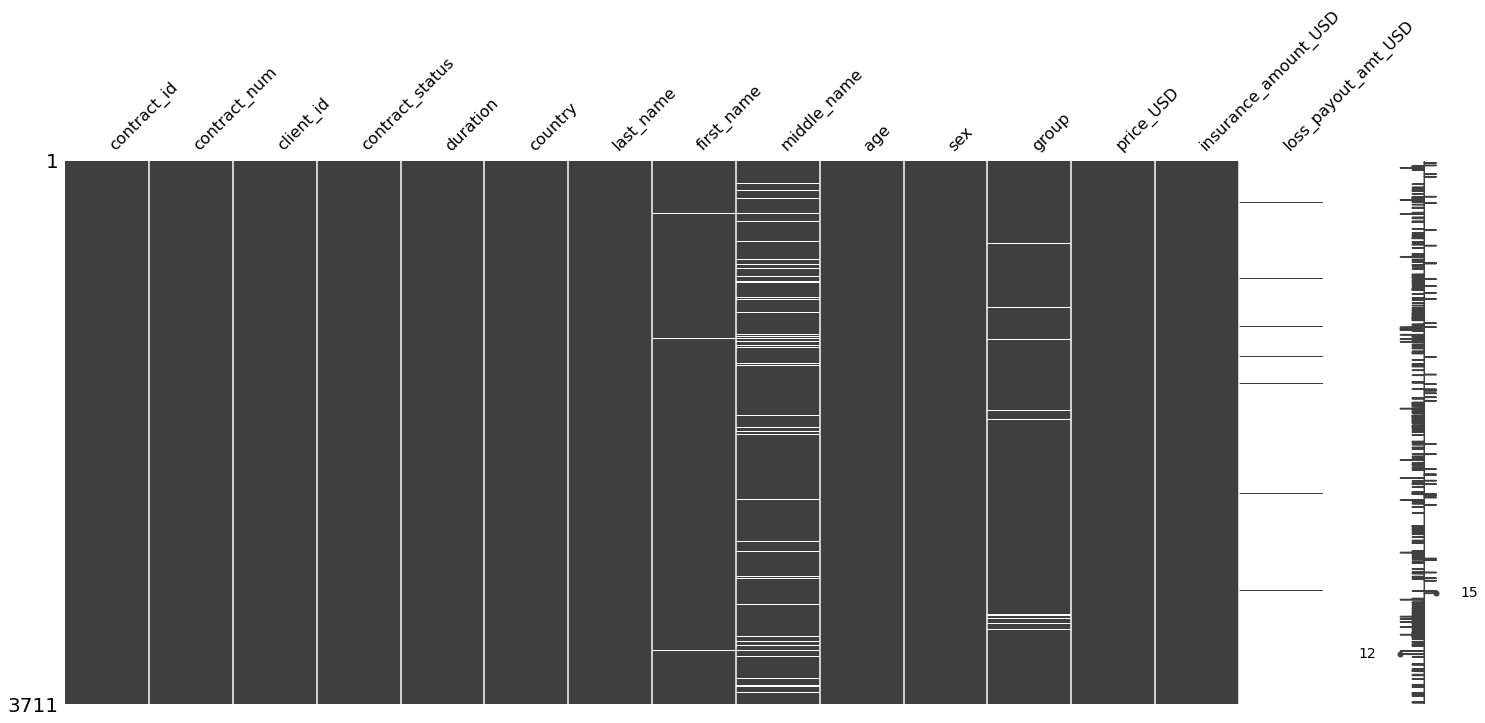

In [426]:
msno.matrix(result)

##### Выводы по оценке пропусков
Пропуски данных наблюдаются в следующих столбцах - 
- в столбцах имени и отчества ('first_name', 'middle_name')
- в столбцах убытков ('loss_payout_amt' и его производная - 'loss_payout_amt_USD')
- в столбце группы по методку работы - пропуск всего 2,6%, заполним значением 'no group'

Данные в целом важные, поэтому удалять строки необходимости нет

Соответственно, заполнение этих столбцов какими-либо методами не правильно. Делаем следующее 
- столбцах имени и отчества ('first_name', 'middle_name') пустые значения заполняем "******"   ,
- в столбцах убытков заполняем пустые значения нулем, т.к. если убытков не было, то значение должно быть нулевым.
- в столбце группы заполняем пустые значения 'no group'

In [427]:
result['first_name']           = result['first_name'].fillna ('******')
result['middle_name']         = result['last_name'].fillna ('******')
result['loss_payout_amt_USD'] = result['loss_payout_amt_USD'].fillna (0)
result['group']         = result['group'].fillna ('no group')

In [428]:
# Смотрим содержание таблицы: количество уникальных значений в столбцах, их список

for column in result:
    print('')
    print('Характеристика:', column)
    uniqvalue = result[column].nunique()
    print('Количество уникальных значений: ', uniqvalue)
    print('Список значений: ',  result[column].value_counts())


Характеристика: contract_id
Количество уникальных значений:  3711
Список значений:  21111219      1
2147557383    1
2147562558    1
2147563984    1
2147566369    1
             ..
2133424332    1
213342438     1
213342514     1
213342662     1
3114463955    1
Name: contract_id, Length: 3711, dtype: int64

Характеристика: contract_num
Количество уникальных значений:  79
Список значений:  ДСЖ-5/1539*****    1389
ТТЕ7227715*****     468
БТАСЕ273 -*****     267
ТТЕ7227778*****     225
ТМГО5Е7 № *****     123
                   ... 
ТМГЩ5Е7 № *****       3
БАЗАМПТЕ57*****       3
БАУБМСТЕ37*****       3
БАЛАМСТЕ56*****       3
БАБАМСТЕ55*****       3
Name: contract_num, Length: 79, dtype: int64

Характеристика: client_id
Количество уникальных значений:  3711
Список значений:  10161870404    1
10054071116    1
1015585145     1
10155945616    1
101561484      1
              ..
100773614      1
10048695563    1
101617148      1
101619598      1
10171539646    1
Name: client_id, Length: 3711,

### 2.2. Проверка заполненности базы

In [429]:
# Проверяем заполненность базы
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки: ', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки: ', round(len(df.dropna())/len(df) * 100, 2))
print_useful_rows_info(result)

Количество полностью заполненных объектов из всей выборки:  3711
Процент полностью заполненных объектов из всей выборки:  100.0


### 2.3. Проверка дублирующих строк

In [430]:
print(f'Количество дублирующих строк в датафрейме - {result[result.duplicated()].shape[0]}')

Количество дублирующих строк в датафрейме - 0


### 2.4. Исследование аномалий

1. Исследованы все поля датасета на предмет аномальности.
2. Действительно аномальным является значение 365 в сроке страховки, но это вполне вероятные данные, если период страховки один год
3. Выделены выбросы по ценовым характеристикам, но они впрямую не могут быть признаны аномальными
4. Есть смысл сделать групповые исследования по числовым характеристикам

In [431]:
result[result['duration']==365].shape[0]

111

In [434]:
df_out = result.drop(columns=['contract_id', 'contract_num', 'group', 'contract_status', 'country', 'last_name', 'first_name', 'middle_name', 'sex'])
df_out.head()

,client_id,duration,age,price_USD,insurance_amount_USD,loss_payout_amt_USD
0,10161870404,10,20,10.90,19890.88,0.0
1,1017159879,7,55,19.08,49727.19,0.0
2,10161883357,10,61,10.90,19890.88,0.0
3,100766461,14,25,15.26,19890.88,0.0
4,10171604758,7,33,19.08,49727.19,0.0


In [435]:
# Оценим весь датасет по методу LOF, при этом оставим в датасете признак возраста
clf = LocalOutlierFactor(n_neighbors =3)   
pred = clf.fit_predict(df_out.drop("client_id", axis =1)) 

In [436]:
print(f"Количество аномальных значений по методу LOF --- {(pred == -1).sum()}") 

Количество аномальных значений по методу LOF --- 363


In [437]:
# Оценим весь датасет по методу изолирующего леса
elf = IsolationForest()   
pred_if = elf.fit_predict(df_out.drop("client_id", axis =1))  
print(f"Количество аномальных значений по методу изолирующего леса --- {(pred_if == -1).sum()}") 

Количество аномальных значений по методу изолирующего леса --- 505


In [438]:
df_out['anomaly'] = np.where(pred == 1, 0, 1)

In [439]:
result = pd.merge(result, df_out[["client_id","anomaly"]], on="client_id", how='left')

In [440]:
result.to_excel('витрина.xlsx', index= False)

# Итоговые выводы раздел 2

1. База заполнена полностью, дублирующих строк нет
2. Необоснованно пустых значений нет, пустоты заполнены нулем либо общими знаками в части ФИО
3. Исследование аномалий ----
      1. Исследованы все поля датасета на предмет аномальности.
      2. Выделены выбросы по ценовым характеристикам, но они впрямую не могут быть признаны аномальными
      3. Есть смысл сделать групповые исследования по числовым характеристикам
      4. При оценке общими методами установлены данные, которые могут быть признаны аномальными.
      5. По методу LOF количество таких данных - 363 строк (10%) и эта цифра похожа на возможную при оценке состава и качества данных датафрейма. По методу Изолирующего леса количество аномальных возросло - до 513 (14%), что вероятнее всего избыточно. В связи с эти оценка аномальности данных принята по методу LOF.
4. В витрину данных добавлен признак аномальности данных по методу LOF

# 3. Кластеризация данных

In [445]:
df = pd.read_excel('витрина.xlsx')
df

,contract_id,contract_num,client_id,contract_status,duration,country,last_name,first_name,middle_name,age,sex,group,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly
0,21111219,ТТЕ7227715*****,10161870404,Действует,10,Беларусь,А*****,Х*****,А*****,20,M,test,10.90,19890.88,0.0,0
1,21111381,ТТЕ7227715*****,1017159879,Действует,7,Индонезия,З*****,Х*****,З*****,55,M,control,19.08,49727.19,0.0,0
2,21112353,БАДАМСТЕ55*****,10161883357,Действует,10,Беларусь,Б*****,В*****,Б*****,61,F,control,10.90,19890.88,0.0,0
3,21113224,ТТЕ7227715*****,100766461,Действует,14,Грузия,И*****,У*****,И*****,25,M,control,15.26,19890.88,0.0,0
4,21113292,ТТЕ7227715*****,10171604758,Действует,7,Аргентина,З*****,Ч*****,З*****,33,M,control,19.08,49727.19,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3706,31133782315,ДСЖ-5/1539*****,100649013,Действует,15,Турция,В*****,В*****,В*****,22,F,control,24.53,29836.31,0.0,0
3707,31133836775,ТТЕ7227778*****,1017151314,Действует,7,Индонезия,Е*****,Ш*****,Е*****,33,M,control,19.08,49727.19,0.0,0
3708,31133933241,БТАСЕ275 -*****,1006491844,Действует,15,Турция,Г*****,Г*****,Г*****,43,M,test,24.53,29836.31,0.0,1
3709,3114463583,ТТЕ7227778*****,1006513037,Действует,30,Турция,Б*****,П*****,Б*****,29,M,control,49.05,29836.31,0.0,1


In [446]:
# Кластеризацию проводим только по изначальной выборке по цене
df_ = df[df['group'] != 'test']
df_

,contract_id,contract_num,client_id,contract_status,duration,country,last_name,first_name,middle_name,age,sex,group,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly
1,21111381,ТТЕ7227715*****,1017159879,Действует,7,Индонезия,З*****,Х*****,З*****,55,M,control,19.08,49727.19,0.0,0
2,21112353,БАДАМСТЕ55*****,10161883357,Действует,10,Беларусь,Б*****,В*****,Б*****,61,F,control,10.90,19890.88,0.0,0
3,21113224,ТТЕ7227715*****,100766461,Действует,14,Грузия,И*****,У*****,И*****,25,M,control,15.26,19890.88,0.0,0
4,21113292,ТТЕ7227715*****,10171604758,Действует,7,Аргентина,З*****,Ч*****,З*****,33,M,control,19.08,49727.19,0.0,0
5,21114111,ДСЖ-5/2771*****,100651616,Действует,30,Турция,Д*****,В*****,Д*****,33,F,control,49.05,29836.31,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705,31133686249,БТАСЕ475 -*****,100647619,Действует,15,Турция,В*****,А*****,В*****,30,M,control,24.53,29836.31,0.0,0
3706,31133782315,ДСЖ-5/1539*****,100649013,Действует,15,Турция,В*****,В*****,В*****,22,F,control,24.53,29836.31,0.0,0
3707,31133836775,ТТЕ7227778*****,1017151314,Действует,7,Индонезия,Е*****,Ш*****,Е*****,33,M,control,19.08,49727.19,0.0,0
3709,3114463583,ТТЕ7227778*****,1006513037,Действует,30,Турция,Б*****,П*****,Б*****,29,M,control,49.05,29836.31,0.0,1


#### 1. Обработка данных перед кластерным анализом
- Удалим столбцы, которые не оказывают никакого влияния на результат аналитики кластеризации
- client_id, contract_id - столбцы идентичные id датасета, поэтому его тоже надо удалить
- также проведем замену признака пола на 0 - мужской и 1 - женский пол
- проведем замену статуса действия контракта - 0- контракт завершен, 1-контракт действует
- в завершении подготовки данные стандартизируем

In [447]:
df_['sex'] = np.where(df_['sex'] == "M", 0, 1)
df_['contract_status'] = np.where(df_['contract_status'] == "Действует", 1, 0)

C:\Users\user\AppData\Local\Temp\ipykernel_109416\4071195867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['sex'] = np.where(df_['sex'] == "M", 0, 1)
C:\Users\user\AppData\Local\Temp\ipykernel_109416\4071195867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['contract_status'] = np.where(df_['contract_status'] == "Действует", 1, 0)


In [448]:
# Стандартизируем данные и удаляем столбцы, ненужные при кластеризации
ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(df[["country"]])
df__ = df_.join(pd.DataFrame(X_ohe.toarray(), columns=ohe.categories_))
df__ = df__.drop(columns=["country", "client_id", "contract_id", "contract_num", "last_name", "group", "first_name", "middle_name"])
df__

,contract_status,duration,age,sex,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly,"(Азербайджан,)","(Аргентина,)",...,"(Иран,)","(Казахстан,)","(Канада,)","(ОАЭ,)","(США,)","(Сирия,)","(Таиланд,)","(Турция,)","(Узбекистан,)","(Франция,)"
1,1,7,55,0,19.08,49727.19,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,10,61,1,10.90,19890.88,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,14,25,0,15.26,19890.88,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,7,33,0,19.08,49727.19,0.0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,30,33,1,49.05,29836.31,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705,1,15,30,0,24.53,29836.31,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3706,1,15,22,1,24.53,29836.31,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3707,1,7,33,0,19.08,49727.19,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3709,1,30,29,0,49.05,29836.31,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [449]:
scaler = StandardScaler()
df_ss = scaler.fit_transform(df__)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


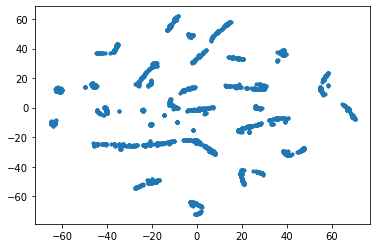

In [450]:
# Снижаем размерность,применяем метод TSNE, визуализируем
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10)

In [451]:
# Метод локтя, оптимальное количество кластеров
categorical_features_idx = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
silhouette = []
N = 10
for k in range(2, N):
    kproto = KPrototypes(n_clusters=2, verbose=2, max_iter=10).fit(df_ss, categorical=categorical_features_idx)
    clusters = kproto.predict(df_ss, categorical=categorical_features_idx)
    silhouette.append(silhouette_score(df_ss, clusters))

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 20, ncost: 15925.434388600901
Run: 1, iteration: 2/10, moves: 0, ncost: 15925.434388600901
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 35, ncost: 16083.148900326809
Run: 2, iteration: 2/10, moves: 0, ncost: 16083.148900326809
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/10, moves: 221, ncost: 18116.71802894564
Run: 3, iteration: 2/10, moves: 175, ncost: 18013.792635830836
Run: 3, iteration: 3/10, moves: 213, ncost: 17750.01343441663
Run: 3, iteration: 4/10, moves: 216, ncost: 17430.340829546014
Run: 3, iteration: 5/10, moves: 8, ncost: 17427.918529769064
Run: 3, iteration: 6/10, moves: 0, ncost: 17427.918529769064
Init: initializing centroids
Init: initializing clusters
Starting 

Starting iterations...
Run: 8, iteration: 1/10, moves: 128, ncost: 16191.38390152581
Run: 8, iteration: 2/10, moves: 10, ncost: 16083.148900326807
Run: 8, iteration: 3/10, moves: 0, ncost: 16083.148900326807
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/10, moves: 264, ncost: 18092.947888662187
Run: 9, iteration: 2/10, moves: 160, ncost: 17965.918904812173
Run: 9, iteration: 3/10, moves: 284, ncost: 17481.110776058424
Run: 9, iteration: 4/10, moves: 71, ncost: 17427.918529769064
Run: 9, iteration: 5/10, moves: 0, ncost: 17427.918529769064
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/10, moves: 21, ncost: 16915.91851534562
Run: 10, iteration: 2/10, moves: 2, ncost: 16886.36857807291
Run: 10, iteration: 3/10, moves: 1, ncost: 16881.663643426757
Run: 10, iteration: 4/10, moves: 0, ncost: 16881.663643426757
Best run was number 8
Initialization method and algorithm are determinist

Run: 4, iteration: 2/10, moves: 0, ncost: 17673.07028970708
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/10, moves: 48, ncost: 18012.2856135667
Run: 5, iteration: 2/10, moves: 24, ncost: 17929.83584231176
Run: 5, iteration: 3/10, moves: 24, ncost: 17889.027328136486
Run: 5, iteration: 4/10, moves: 1, ncost: 17888.935281794133
Run: 5, iteration: 5/10, moves: 0, ncost: 17888.935281794133
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/10, moves: 221, ncost: 17816.00605479549
Run: 6, iteration: 2/10, moves: 24, ncost: 17799.606383468043
Run: 6, iteration: 3/10, moves: 2, ncost: 17799.508884159935
Run: 6, iteration: 4/10, moves: 0, ncost: 17799.508884159935
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/10, moves: 326, ncost: 17536.71416664638
Run: 7, iteration: 2/10, moves: 149, ncost: 17356.45386473647
Run: 7, iteration: 3/10, 

Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/10, moves: 184, ncost: 17813.220282550694
Run: 6, iteration: 2/10, moves: 135, ncost: 17440.08478977032
Run: 6, iteration: 3/10, moves: 5, ncost: 17438.202395683373
Run: 6, iteration: 4/10, moves: 0, ncost: 17438.202395683373
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/10, moves: 157, ncost: 18120.689035374387
Run: 7, iteration: 2/10, moves: 82, ncost: 18097.108894447647
Run: 7, iteration: 3/10, moves: 33, ncost: 18093.545389609146
Run: 7, iteration: 4/10, moves: 8, ncost: 18093.15345067823
Run: 7, iteration: 5/10, moves: 0, ncost: 18093.15345067823
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/10, moves: 39, ncost: 18144.92188306204
Run: 8, iteration: 2/10, moves: 4, ncost: 18144.824760383333
Run: 8, iteration: 3/10, moves: 0, ncost: 18144.82476038

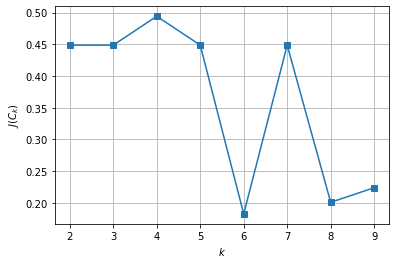

In [452]:
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

#### Таким образом, принимаем оптимальное количество кластеров = 4

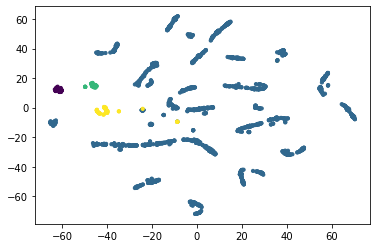

In [453]:
# Метод К-средних, визуализация
kmeans = KMeans(n_clusters=4).fit(df_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=kmeans.labels_)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/10, moves: 485, ncost: 13256.28242526904
Run: 1, iteration: 2/10, moves: 103, ncost: 11871.132525518535
Run: 1, iteration: 3/10, moves: 0, ncost: 11871.132525518535
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/10, moves: 255, ncost: 12126.364121834968
Run: 2, iteration: 2/10, moves: 93, ncost: 11816.435446854848
Run: 2, iteration: 3/10, moves: 1, ncost: 11814.13756341634
Run: 2, iteration: 4/10, moves: 0, ncost: 11814.13756341634
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/10, moves: 385, ncost: 13264.636559291495
Run: 3, iteration: 2/10, moves: 274, ncost: 12330.127755598876
Run: 3, iteration: 3/10, moves: 41, ncost: 12268.881977298426
Run: 3, iteration: 4/10, moves: 0, ncost: 12268.881977298426
Init

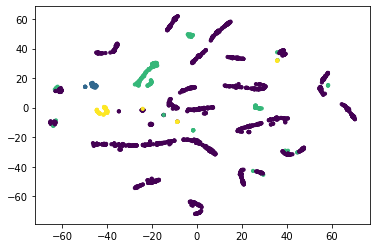

In [454]:
kproto = KPrototypes(n_clusters=4, verbose=2, max_iter=10).fit(df_ss, categorical=categorical_features_idx)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=kproto.labels_)

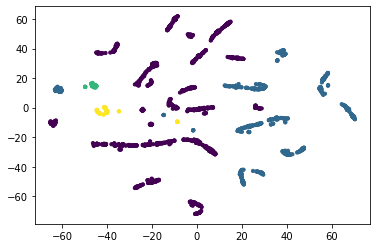

In [455]:
# Иерархический метод, визуализация
clustering = AgglomerativeClustering(n_clusters=4).fit(df_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_)

#####  В целом и метод К-средних и иерархический метод показывают неплохие результаты кластеризации, хотя кажется, что метод иерархии - лучше. Проверим данный вывод

#### Сравнение методов

K=1 skipped. Mean computed from data directly.
K=2 fitted in 1.030 seconds.
K=3 fitted in 1.464 seconds.
K=4 fitted in 1.696 seconds.
K=5 fitted in 2.147 seconds.
K=6 fitted in 2.164 seconds.
K=7 fitted in 2.461 seconds.
K=8 fitted in 2.473 seconds.
K=9 fitted in 2.767 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

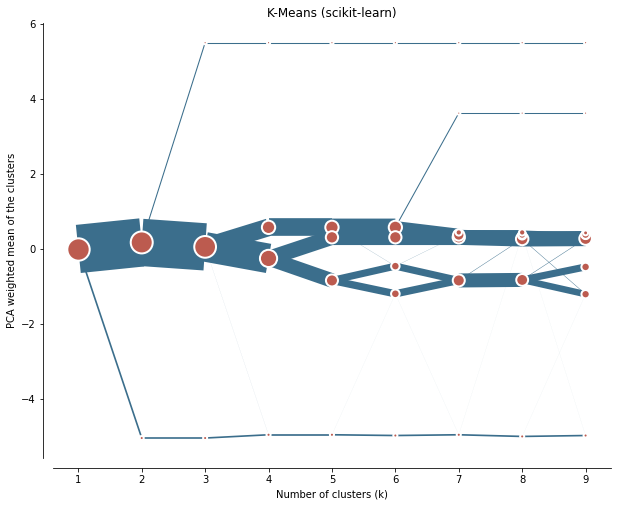

In [456]:
cgram = Clustergram(range(1, 10), n_init=1000)
cgram.fit(df_ss)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('K-Means (scikit-learn)')

Text(0.5, 1.0, 'Hierarchical (scikit-learn)')

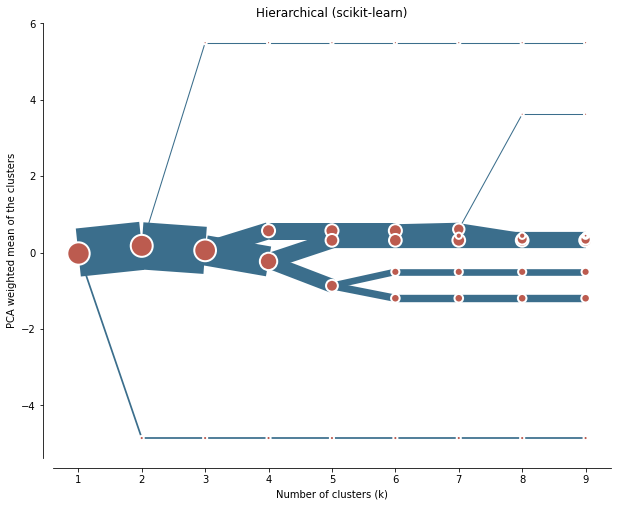

In [457]:
cgram = Clustergram(range(1, 10), method='hierarchical', linkage='ward')
cgram.fit(df_ss)

ax = cgram.plot(
    figsize=(10, 8),
    line_style=dict(color=ugg.COLORS[1]),
    cluster_style={"color": ugg.COLORS[2]},
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title('Hierarchical (scikit-learn)')

#### Таким образом график явно показыает лучшие результаты  кластеризации иерархическим методом

##### Визуализируем кластеры

In [458]:
df_normalized = pd.DataFrame(df_ss, columns=['contract_status',             'duration',                  'age',
                        'sex',            'price_USD', 'insurance_amount_USD',
        'loss_payout_amt_USD',              'anomaly',       ('Азербайджан',),
               ('Аргентина',),           ('Армения',),          ('Беларусь',),
                ('Болгария',),    ('Великобритания',),          ('Германия',),
                  ('Грузия',),            ('Египет',),         ('Индонезия',),
                    ('Иран',),         ('Казахстан',),            ('Канада',),
                     ('ОАЭ',),               ('США',),             ('Сирия',),
                 ('Таиланд',),            ('Турция',),        ('Узбекистан',),
                 ('Франция',)])

In [459]:
df_normalized['Cluster'] = clustering.labels_

In [460]:
df_normalized = df_normalized.rename(columns={('Азербайджан',): 'Азербайджан', ('Аргентина',): 'Аргентина',
                                    ('Армения',): 'Армения', ('Беларусь',): 'Беларусь',
                                     ('Болгария',): 'Болгария', ('Великобритания',): 'Великобритания',
                                     ('Германия',): 'Германия', ('Грузия',): 'Грузия',
                                     ('Египет',): 'Египет', ('Индонезия',): 'Индонезия',
                                     ('Иран',): 'Иран', ('Казахстан',): 'Казахстан',
                                      ('Канада',): 'Канада', ('ОАЭ',): 'ОАЭ',
                                      ('США',): 'США', ('Сирия',): 'Сирия',
                                      ('Таиланд',): 'Таиланд', ('Турция',): 'Турция',
                                      ('Узбекистан',): 'Узбекистан', ('Франция',): 'Франция'},
                                      )

In [461]:
df_normalized['ID'] = df_normalized.index

In [462]:
df_normalized.columns

Index(['contract_status', 'duration', 'age', 'sex', 'price_USD',
       'insurance_amount_USD', 'loss_payout_amt_USD', 'anomaly', 'Азербайджан',
       'Аргентина', 'Армения', 'Беларусь', 'Болгария', 'Великобритания',
       'Германия', 'Грузия', 'Египет', 'Индонезия', 'Иран', 'Казахстан',
       'Канада', 'ОАЭ', 'США', 'Сирия', 'Таиланд', 'Турция', 'Узбекистан',
       'Франция', 'Cluster', 'ID'],
      dtype='object')

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

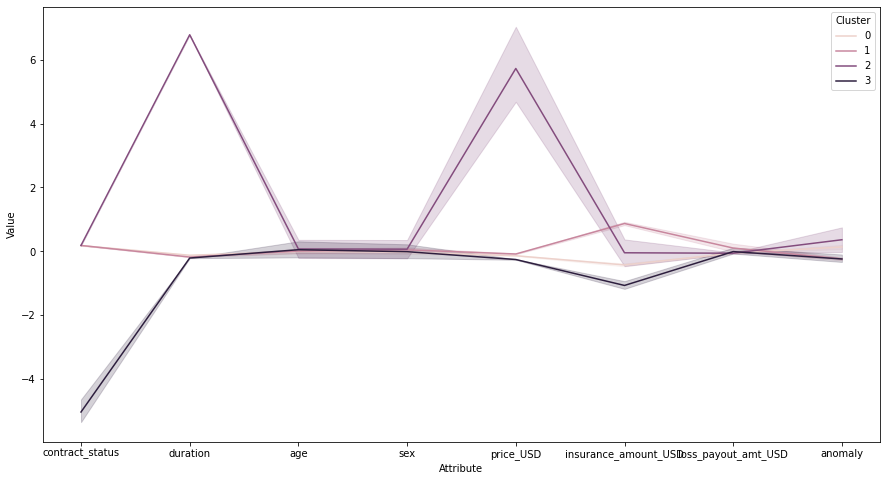

In [463]:
# Визуализация кластеров
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID','Cluster'],
                      value_vars=['contract_status', 'duration','age','sex', 'price_USD', 'insurance_amount_USD',
                                  'loss_payout_amt_USD', 'anomaly'],
                      var_name='Attribute',
                      value_name='Value')
plt.figure(figsize=(15,8))
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

##### Как видно из графика - кластеры практически не отличаются по полу и возрасту, а также по величине убытков, поэтому уберем эти поля из рассмотрения и добавим страны

#### Также из графика явно видно, что основные признаки кластеризации - это срок страхования и цена страховки

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

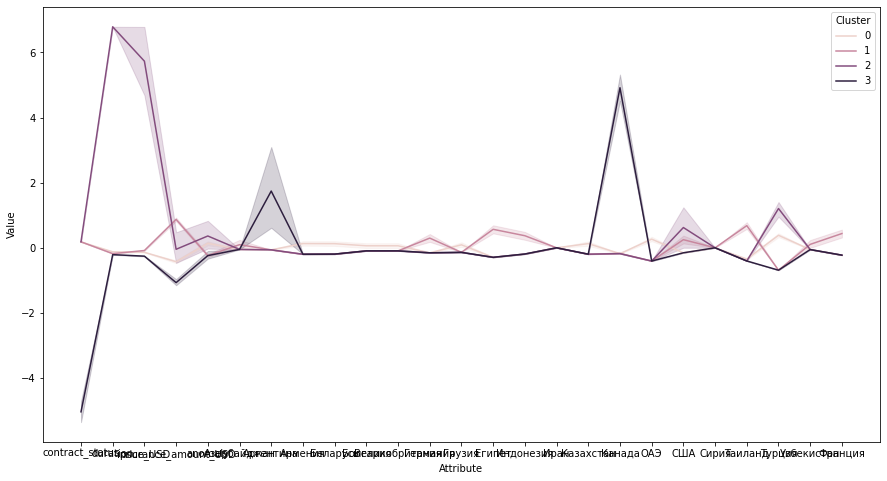

In [464]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID','Cluster'],
                      value_vars=['contract_status', 'duration','price_USD', 'insurance_amount_USD',
                                  'anomaly', 'Азербайджан', 'Аргентина', 'Армения', 'Беларусь', 
                                  'Болгария', 'Великобритания', 'Германия', 'Грузия', 'Египет', 'Индонезия', 'Иран', 
                                  'Казахстан', 'Канада', 'ОАЭ', 'США', 'Сирия', 'Таиланд', 'Турция', 'Узбекистан','Франция'],
                      var_name='Attribute',
                      value_name='Value')
plt.figure(figsize=(15,8))
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

##### Из данного графика видно, что кластеризация непосредственно проведена и по признаку стран 

# Итоговые выводы раздел 3

1. Таким образом, как видно из кластерграм иерархический метод показывает явно более качественные результаты, чем метод К-средних.
2. Кластеризацию стоит делать именно по результатам иерархического метода с количеством кластеров =4, увеличивать количество кластеров нецелесообразно
3. Основными признаками кластеризации являются срок страхования, цена страховки и страна

## 4. А/В-тестирование старого и нового подходов к формированию стоимости полиса ВЗР

Первый подход включает в себя традиционную оценку рисков, а второй — использование результатов кластеризации.

Основные влияющие факторы: цена полиса, конверсия в оформления и убыточность.

#### Так как не вся информация ясна по вводным данным, при исполнении задания будем считать следующее:
- в файле 'experiment_group' показаны все клиенты, попавшие в воронку продаж компании (первый этап воронки) -- 14 842 кл.
- в файле 'experiment_group' показаны клиенты, распавшиеся по группам эксперимента - которым, видимо, был сделан просчет страховки (второй этап воронки) -- 12 349 кл
- в файле 'contracts' общее количество клиентов (контрактов) показывает клиентов, которые попали в третий этап воронки (пусть будут переговоры) ----  3 711 кл
- в файле 'contracts' действующий статус контракта отражает четвертый этап воронки - реальные продажи, т.е. это показатель конверсии в продажи  ---- 3 315 кл

### 4.1. Готовим данные

In [308]:
group = pd.read_excel('17.5 experiment_group.xlsx')
print(group.shape)
x = group.shape[0] - group['group'].isnull().sum ()
print(f'Количество клиентов, попавших в группы ---- {x}')
group.head(2)

(14842, 3)
Количество клиентов, попавших в группы ---- 12349


,client_id,group,experiment_id
0,10001718,control,policy_pricing
1,1017180395,control,policy_pricing


In [314]:
print(df.shape)
x = df[df['contract_status'] == 1].shape[0]
print(f'Количество контрактов со статусом "Действует" ---- {x}')
df.head(2)

(3711, 15)
Количество контрактов со статусом "Действует" ---- 3315


,contract_id,contract_num,client_id,contract_status,duration,country,last_name,first_name,middle_name,age,sex,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly
0,21111219,ТТЕ7227715*****,10161870404,1,10,Беларусь,А*****,Х*****,А*****,20,0,10.97,20015.05,0.0,0
1,21111381,ТТЕ7227715*****,1017159879,1,7,Индонезия,З*****,Х*****,З*****,55,0,19.19,50037.62,0.0,0


In [315]:
# Объединяем таблицы в одну
result = pd.merge(df, group[["client_id", "group"]], on = "client_id", how='left')
result.head(3)

,contract_id,contract_num,client_id,contract_status,duration,country,last_name,first_name,middle_name,age,sex,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly,group
0,21111219,ТТЕ7227715*****,10161870404,1,10,Беларусь,А*****,Х*****,А*****,20,0,10.97,20015.05,0.0,0,test
1,21111381,ТТЕ7227715*****,1017159879,1,7,Индонезия,З*****,Х*****,З*****,55,0,19.19,50037.62,0.0,0,control
2,21112353,БАДАМСТЕ55*****,10161883357,1,10,Беларусь,Б*****,В*****,Б*****,61,1,10.97,20015.05,0.0,0,control


In [317]:
# Удаляем ненужные столбцы из таблицы
result = result.drop(columns= ['contract_num', 'last_name', 'first_name', 'middle_name'])

In [318]:
result.head(3)

,contract_id,client_id,contract_status,duration,country,age,sex,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly,group
0,21111219,10161870404,1,10,Беларусь,20,0,10.97,20015.05,0.0,0,test
1,21111381,1017159879,1,7,Индонезия,55,0,19.19,50037.62,0.0,0,control
2,21112353,10161883357,1,10,Беларусь,61,1,10.97,20015.05,0.0,0,control


In [319]:
print(result['group'].unique())

['test' 'control' nan]


In [320]:
# Делим датафрейм на две выборки
test = result[result['group']=='test']
control = result[result['group']=='control']
print(f'Количество клиентов в группе "test" ---- {test.shape[0]}')
print(f'Количество клиентов в группе "control" ---- {control.shape[0]}')

Количество клиентов в группе "test" ---- 1667
Количество клиентов в группе "control" ---- 1949


### 4.2. Исследуем гипотезы

#### 4.2.1.  Исследуем первую гипотезу по ценам страховки
H0 - цены страхования равноценны как при традиционной методике, так и при использовании кластеризации с заданным уровнем оценки в 5%

Н1 - цены страхования отличаются при заданном уровне оценки в 5%

In [321]:
ttest_ind(control['price_USD'], test['price_USD'], equal_var= False)

TtestResult(statistic=-2.352614853341849, pvalue=0.018699878307990414, df=3326.506246589711)

#### Вывод
При сравнении выборок по цене страховки, т.к. p-value <0,05, мы не можем принять гипотезу о равенстве цен и суммы страховки в выборкахс экспериментом и без него, т.е. цены страхования отличаются

#### 4.2.2. Исследуем вторую гипотезу по сумме страхования
H0 - суммы страхования равноценны как при традиционной методике, так и при использовании кластеризации с заданным уровнем оценки в 5%

Н1 - суммы  страхования отличаются при заданном уровне оценки в 5%

In [323]:
ttest_ind(control['insurance_amount_USD'], test['insurance_amount_USD'], equal_var= False)

TtestResult(statistic=11.69056492083666, pvalue=5.641803952473376e-31, df=3351.427757821664)

#### Вывод
При сравнении выборок по общей сумме страховки, т.к. p-value <0,05, мы не можем принять гипотезу о равенстве суммы страховки в выборках с экспериментом и без него, т.е. суммы страхования отличаются

#### 4.2.3. Исследуем третью гипотезу по суммам убытков
H0 - суммы убытков равноценны как при традиционной методике, так и при использовании кластеризации с заданным уровнем оценки в 5%

Н1 - суммы убытков отличаются при заданном уровне оценки в 5%

In [324]:
ttest_ind(control['loss_payout_amt_USD'], test['loss_payout_amt_USD'], equal_var= False)

TtestResult(statistic=0.7894536904578213, pvalue=0.4298993795144862, df=3565.529728050716)

#### Вывод
При сравнении выборок по стоимости убытков, т.к. p-value существенно >0,05, мы с большой долей вероятности можем предположить, что сумма убытков не зависит от проведения эксперимента (с большой долей вероятности принимаем верность нулевой гипотезы)

#### 4.2.4. Исследуем четвертую гипотезу о конверсии в результат
H0 - конверсии в результат равноценны как при традиционной методике, так и при использовании кластеризации с заданным уровнем оценки в 5%

Н1 - конверсии в результат отличаются при заданном уровне оценки в 5%

In [325]:
ttest_ind(control['contract_status'], test['contract_status'], equal_var= False)

TtestResult(statistic=15.392006679043531, pvalue=6.554122494534892e-51, df=2254.721371927242)

#### Вывод
При сравнении выборок по конверсии в продажи, т.к. p-value существенно <0,05, мы не можем принять гипотезу о равенстве конверсий в выборках с экспериментом и без него.

In [329]:
test

,contract_id,client_id,contract_status,duration,country,age,sex,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly,group
0,21111219,10161870404,1,10,Беларусь,20,0,10.97,20015.05,0.0,0,test
33,21132473,100660134,1,30,Турция,33,0,49.36,30022.57,0.0,0,test
36,211329637,100660718,1,30,Турция,45,0,49.36,30022.57,0.0,0,test
38,21133319,100661134,1,30,Турция,50,1,49.36,30022.57,0.0,1,test
43,211336588,100663119,1,30,Турция,42,0,49.36,30022.57,0.0,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...
3698,31132852132,100634083,1,15,Турция,43,0,24.68,30022.57,0.0,1,test
3699,31133183572,101611554,1,10,Беларусь,45,0,10.97,20015.05,0.0,0,test
3702,31133453443,10161571146,1,10,Беларусь,34,0,10.97,20015.05,0.0,0,test
3704,31133671497,1016163597,1,10,Беларусь,45,0,10.97,20015.05,0.0,0,test


In [339]:
print(f"Процент конверсии в результат в эксперименте --- {(test[test['contract_status']==1].shape[0] / test.shape[0] * 100)}")
print(f"Процент конверсии в результат в традиц. методе --- {(control[control['contract_status']==1].shape[0] / control.shape[0] * 100)}")

Процент конверсии в результат в эксперименте --- 80.26394721055789
Процент конверсии в результат в традиц. методе --- 96.5623396613648


### Общие выводы по разделу 4
1. Конверсия в результат выше в традиционном расчете (80% тест и 96,6% в контрольной выборке, разница в 16,3%, т.е. около 272 условно "потерянных" контрактов)
2. Суммы убытков в обоих случаях с равноценны при заданном уровне значимости
3. Цены и суммы страхования отличаются в обоих случаях

In [333]:
null_conv = result[result['contract_status']==0]
null_conv

,contract_id,client_id,contract_status,duration,country,age,sex,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly,group
408,212318439,10198319514,0,10,Болгария,45,1,10.97,20015.05,0.0,0,control
411,21231952,1039411170,0,10,Канада,56,1,10.97,20015.05,0.0,0,control
416,212323658,1039531590,0,10,Канада,57,0,10.97,20015.05,0.0,1,control
419,212324583,1039804158,0,10,Канада,32,0,10.97,20015.05,0.0,0,control
421,212325179,10411106478,0,10,Канада,50,1,10.97,20015.05,0.0,0,control
...,...,...,...,...,...,...,...,...,...,...,...,...
3135,217387337,100173416,0,14,США,51,1,38.00,50000.00,0.0,0,test
3140,21739748,100174111,0,14,США,35,0,38.00,50000.00,0.0,0,test
3151,217424653,10017631307,0,14,США,21,0,38.00,50000.00,0.0,1,test
3176,217458696,1001775111,0,14,США,43,1,38.00,50000.00,0.0,0,test


In [346]:
test[test['contract_status'] == 1].shape[0]

1338

In [349]:
x = test[(test['loss_payout_amt_USD'] > 0)].shape[0] / (test[test['contract_status'] == 1].shape[0]) * 100
print(f'Процент контрактов с убытками к общему количеству действующих контрактов на тесте --- {x}')
y = control[(control['loss_payout_amt_USD'] > 0)].shape[0] / (control[control['contract_status'] == 1].shape[0]) * 100
print(f'Процент контрактов с убытками к общему количеству действующих контрактов на традиц. мет. --- {y}')

Процент контрактов с убытками к общему количеству действующих контрактов на тесте --- 1.046337817638266
Процент контрактов с убытками к общему количеству действующих контрактов на традиц. мет. --- 1.5940488841657812


#### Таким образом количество контрактов с убытками выше при прежней методике расчета, разница в 0,55%, т.е. где-то 9-10 случаев 

In [351]:
null_conv_test = test[test['contract_status']==0].sort_values(by ='price_USD', ascending = False)
null_conv_test

,contract_id,client_id,contract_status,duration,country,age,sex,price_USD,insurance_amount_USD,loss_payout_amt_USD,anomaly,group
3177,217458745,10017974079,0,14,США,89,0,38.00,50000.00,0.0,1,test
1276,213358495,10165351517,0,14,США,43,1,38.00,50000.00,0.0,0,test
1728,213749734,1001076038,0,14,США,32,1,38.00,50000.00,0.0,0,test
1725,21374896,1001031516,0,14,США,56,1,38.00,50000.00,0.0,0,test
1724,213748321,10010096633,0,14,США,44,1,38.00,50000.00,0.0,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...
929,212933135,100157950,0,10,Азербайджан,34,0,5.48,10007.52,0.0,0,test
931,212933324,10016033411,0,10,Азербайджан,32,0,5.48,10007.52,0.0,0,test
1597,213636583,108848740,0,10,Азербайджан,44,1,5.48,10007.52,0.0,1,test
939,212937623,1001643798,0,10,Азербайджан,24,1,5.48,10007.52,0.0,1,test


In [388]:
# По данным с экспериментальными ценами
print("ПОКАЗАТЕЛИ ПО ДАННЫМ С КЛАСТЕРИЗАЦИЕЙ (НА ТЕСТЕ)")
print(f'Количество контрактов  --- {test.shape[0]}')
print(f"Количество контрактов c убытками  --- {test[(test['loss_payout_amt_USD'] > 0)].shape[0]}")
print(f"Процент кол-ва контрактов c убытками к действ. контрактам  --- {(test[(test['loss_payout_amt_USD'] > 0)].shape[0])/(test[test['contract_status'] == 1].shape[0]) * 100} %")

print(f"Сумма дохода по действующим контрактам  --- {(test[test['contract_status']==1]['price_USD'].sum())} долл.")
print(f"Сумма по потерянным контрактам  --- {(null_conv_test['price_USD'].sum())} долл.")
print(f"Сумма убытков по контрактам --- {(test['loss_payout_amt_USD'].sum())} долл.")
print(f"Процент суммы убытков к сумме дохода по действ. контрактам --- {(test['loss_payout_amt_USD'].sum())/(test[test['contract_status']==1]['price_USD'].sum()) * 100} %")

ПОКАЗАТЕЛИ ПО ДАННЫМ С КЛАСТЕРИЗАЦИЕЙ (НА ТЕСТЕ)
Количество контрактов  --- 1667
Количество контрактов c убытками  --- 14
Процент кол-ва контрактов c убытками к действ. контрактам  --- 1.046337817638266 %
Сумма дохода по действующим контрактам  --- 86266.65 долл.
Сумма по потерянным контрактам  --- 3438.13 долл.
Сумма убытков по контрактам --- 34425.91 долл.
Процент суммы убытков к сумме дохода по действ. контрактам --- 39.90639488145188 %


In [465]:
test[test['contract_status'] == 1].shape[0]

1338

In [466]:
control[control['contract_status'] == 1].shape[0]

1882

In [389]:
# По данным с традиционным методом
print("ПОКАЗАТЕЛИ ПО ДАННЫМ  С ТРАДИЦИОННЫМ МЕТОДОМ")
print(f'Количество контрактов  --- {control.shape[0]}')
print(f"Количество контрактов c убытками  --- {control[(control['loss_payout_amt_USD'] > 0)].shape[0]}")
print(f"Процент кол-ва контрактов c убытками к действ. контрактам  --- {(control[(control['loss_payout_amt_USD'] > 0)].shape[0])/(control[control['contract_status'] == 1].shape[0]) * 100} %")

print(f"Сумма дохода по действующим контрактам --- {(control[control['contract_status']==1]['price_USD'].sum())} долл.")
print(f"Сумма по потерянным контрактам  --- {(control[control['contract_status']==0]['price_USD'].sum())} долл.")
print(f"Сумма убытков по контрактам  --- {(control['loss_payout_amt_USD'].sum())} долл.")
print(f"Процент суммы убытков к сумме дохода по действ. контрактам --- {(control['loss_payout_amt_USD'].sum())/(control[control['contract_status']==1]['price_USD'].sum()) * 100} %")

ПОКАЗАТЕЛИ ПО ДАННЫМ  С ТРАДИЦИОННЫМ МЕТОДОМ
Количество контрактов  --- 1949
Количество контрактов c убытками  --- 30
Процент кол-ва контрактов c убытками к действ. контрактам  --- 1.5940488841657812 %
Сумма дохода по действующим контрактам --- 82911.26000000001 долл.
Сумма по потерянным контрактам  --- 734.9900000000001 долл.
Сумма убытков по контрактам  --- 63848.01000000001 долл.
Процент суммы убытков к сумме дохода по действ. контрактам --- 77.00764648854691 %


### ОБЩИЕ ВЫВОДЫ
Общие результаты следующие --- 
1. Основной проблемой являлись большие суммы выплат по страховке - 77% от общей суммы доходов
2. При этом количество страховых случаев было небольшим - всего 1,6%, а конверсия в страховку достигала 96%
3. При изменении системы определения цены страхования и суммы страховки, процент конверсии существенно (но не критично) снизился - на 16% и достиг 80%, а потеря дохода по несостоявшимся контрактам увеличилась в 4 раза
4. Но при этом удалось снизить количество страховых случаев (на 0,5%) и (что самое главное!!), существенно снизить суммы выплат по страховым случаям - почти в два раза - с 77% до 40%!
5. Потеря дохода по несостоявшимся страховкам несоизмерима с размером выплат по страховым случаям, поэтому при выборе показателя, с которым следует работать в первую очередь, - это снижение размера страховых выплат, а потом уже работать с конверсией.

#### Таким образом, методика кластеризации клиентов при формировании цены и размера страховки полностью подтверждает свою эффективность и  продуктивность. 
#### Следует продолжить работать в данном направлении и далее, снижая количество страховых выплат при достаточном уровне конверсии в результат.